In [1]:
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import os.path
import graph_tool as gt
import nn2graph
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape((-1, X_train.shape[1] * X_train.shape[2]))
X_test = X_test.reshape((-1, X_test.shape[1] * X_test.shape[2]))
y_train_orig, y_test_orig = y_train, y_test
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [3]:
hidden_dims = 64
input_dims = X_train.shape[1]
input_0 = Input((input_dims,))
dense_1 = Dense(hidden_dims, activation='relu', kernel_initializer='he_uniform')(input_0)
dense_2 = Dense(hidden_dims, activation='relu', kernel_initializer='he_uniform')(dense_1)
dense_3 = Dense(hidden_dims, activation='relu', kernel_initializer='he_uniform')(dense_2)
dense_4 = Dense(hidden_dims, activation='relu', kernel_initializer='he_uniform')(dense_3)
dense_out = Dense(10, activation='softmax', kernel_initializer='he_uniform')(dense_4)
model = Model(inputs=input_0, outputs=dense_out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [4]:
load_saved_model = True
if load_saved_model and os.path.exists('data/outputs/mnist_dnn_4x64_10.h5'):
    model = load_model('data/outputs/mnist_dnn_4x64_10.h5')
else:
    model.fit(X_train, y_train, epochs=5)
    model.save('data/outputs/mnist_dnn_4x64_10.h5')

In [5]:
model.evaluate(X_test, y_test, verbose=0)

[0.2403999562524259, 0.9354]

In [6]:
g_full, g_xs = nn2graph.dense_activations_to_graph(model, X_test[:5000])

In [11]:
i_max = np.argmax([g.num_edges() for g in g_xs])
i_min = np.argmin([g.num_edges() for g in g_xs])
g_max = g_xs[i_max]
g_min = g_xs[i_min]
g_by_class = [[g for j, g in enumerate(g_xs) if y_test_orig[j] == i] for i in range(10)]

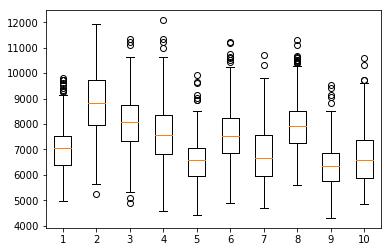

In [13]:
g_xs_edge_counts_by_class = [[g.num_edges() for g in gs] for gs in g_by_class]
plt.boxplot(g_xs_edge_counts_by_class)
plt.show()

In [ ]:
for gs in g_by_class:
    for g in gs:
        g.vp['degree'] = g.degree_property_map('total', weight=g.vp['weight'])


In [10]:
from graph_tool.centrality import eigenvector
eig_max, eig_vp = eigenvector(g, weight=g.ep['weight'], max_iter=1.0E5)

In [11]:
eig_centralities = [(g.vertex_index[v], eig_vp[v]) for v in g.vertices()]

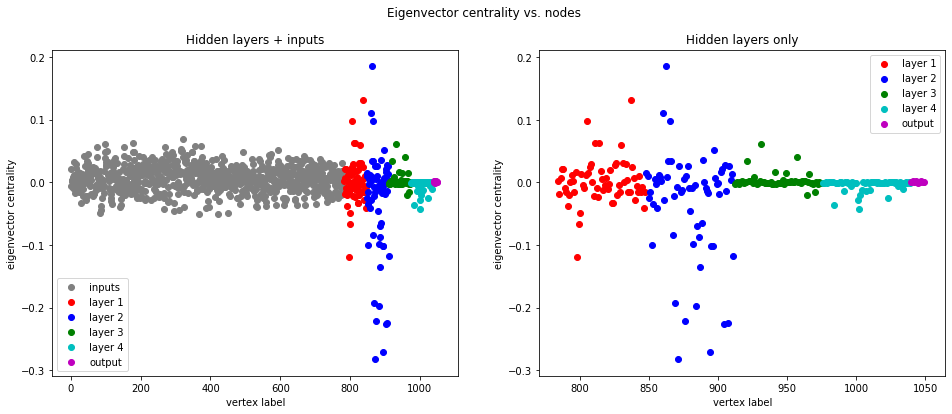

In [12]:
vs_in = [v for v,_ in eig_centralities if v < input_dims]
eigs_in = [eigc for v, eigc in eig_centralities if v < input_dims]
vs1 = [v for v,_ in eig_centralities if v >= input_dims and v < input_dims+hidden_dims]
eigs1 = [eigc for v, eigc in eig_centralities if v >= input_dims and v < input_dims+hidden_dims]
vs2 = [v for v,_ in eig_centralities if v >= input_dims+hidden_dims and v < input_dims+2*hidden_dims]
eigs2 = [eigc for v, eigc in eig_centralities if v >= input_dims+hidden_dims and v < input_dims+2*hidden_dims]
vs3 = [v for v,_ in eig_centralities if v >= input_dims+2*hidden_dims and v < input_dims+3*hidden_dims]
eigs3 = [eigc for v, eigc in eig_centralities if v >= input_dims+2*hidden_dims and v < input_dims+3*hidden_dims]
vs4 = [v for v,_ in eig_centralities if v >= input_dims+3*hidden_dims and v < input_dims+4*hidden_dims]
eigs4 = [eigc for v, eigc in eig_centralities if v >= input_dims+3*hidden_dims and v < input_dims+4*hidden_dims]
vs_out = [v for v,_ in eig_centralities if v >= input_dims+4*hidden_dims]
eigs_out = [eigc for v, eigc in eig_centralities if v >= input_dims+4*hidden_dims]
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(vs_in, eigs_in, c='gray')
plt.scatter(vs1, eigs1, c='r')
plt.scatter(vs2, eigs2, c='b')
plt.scatter(vs3, eigs3, c='g')
plt.scatter(vs4, eigs4, c='c')
plt.scatter(vs_out, eigs_out, c='m')
plt.legend(['inputs', 'layer 1', 'layer 2', 'layer 3', 'layer 4', 'output'])
plt.xlabel('vertex label')
plt.ylabel('eigenvector centrality')
plt.title('Hidden layers + inputs')
plt.subplot(1,2,2)
plt.scatter(vs1, eigs1, c='r')
plt.scatter(vs2, eigs2, c='b')
plt.scatter(vs3, eigs3, c='g')
plt.scatter(vs4, eigs4, c='c')
plt.scatter(vs_out, eigs_out, c='m')
plt.legend(['layer 1', 'layer 2', 'layer 3', 'layer 4', 'output'])
plt.xlabel('vertex label')
plt.ylabel('eigenvector centrality')
plt.title('Hidden layers only')
plt.suptitle('Eigenvector centrality vs. nodes')
plt.show()

In [11]:
from graph_tool.centrality import katz
katz_vp = katz(g, alpha=0.1, weight=g.ep['weight'])
katz_centralities = [(g.vertex_index[v], katz_vp[v]) for v in g.vertices()]

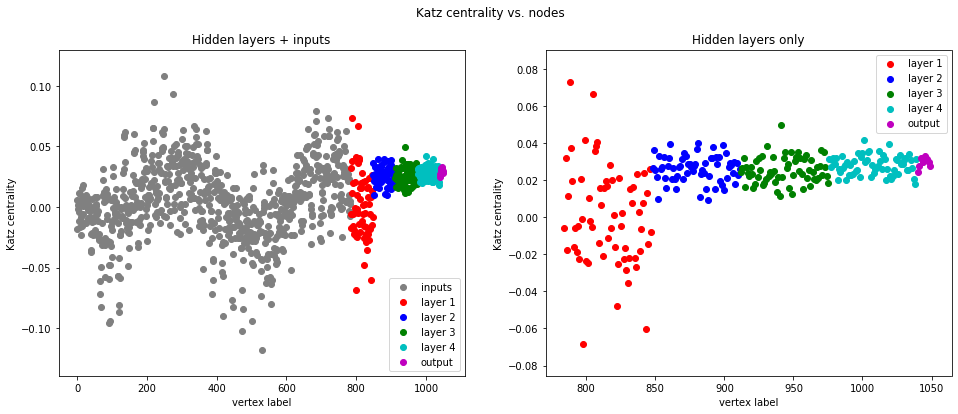

In [12]:
vs_in = [v for v,_ in katz_centralities if v < input_dims]
eigs_in = [eigc for v, eigc in eig_centralities if v < input_dims]
vs1 = [v for v,_ in katz_centralities if v >= input_dims and v < input_dims+hidden_dims]
eigs1 = [eigc for v, eigc in katz_centralities if v >= input_dims and v < input_dims+hidden_dims]
vs2 = [v for v,_ in katz_centralities if v >= input_dims+hidden_dims and v < input_dims+2*hidden_dims]
eigs2 = [eigc for v, eigc in katz_centralities if v >= input_dims+hidden_dims and v < input_dims+2*hidden_dims]
vs3 = [v for v,_ in katz_centralities if v >= input_dims+2*hidden_dims and v < input_dims+3*hidden_dims]
eigs3 = [eigc for v, eigc in katz_centralities if v >= input_dims+2*hidden_dims and v < input_dims+3*hidden_dims]
vs4 = [v for v,_ in katz_centralities if v >= input_dims+3*hidden_dims and v < input_dims+4*hidden_dims]
eigs4 = [eigc for v, eigc in katz_centralities if v >= input_dims+3*hidden_dims and v < input_dims+4*hidden_dims]
vs_out = [v for v,_ in katz_centralities if v >= input_dims+4*hidden_dims]
eigs_out = [eigc for v, eigc in katz_centralities if v >= input_dims+4*hidden_dims]
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(vs_in, eigs_in, c='gray')
plt.scatter(vs1, eigs1, c='r')
plt.scatter(vs2, eigs2, c='b')
plt.scatter(vs3, eigs3, c='g')
plt.scatter(vs4, eigs4, c='c')
plt.scatter(vs_out, eigs_out, c='m')
plt.legend(['inputs', 'layer 1', 'layer 2', 'layer 3', 'layer 4', 'output'])
plt.xlabel('vertex label')
plt.ylabel('Katz centrality')
plt.title('Hidden layers + inputs')
plt.subplot(1,2,2)
plt.scatter(vs1, eigs1, c='r')
plt.scatter(vs2, eigs2, c='b')
plt.scatter(vs3, eigs3, c='g')
plt.scatter(vs4, eigs4, c='c')
plt.scatter(vs_out, eigs_out, c='m')
plt.legend(['layer 1', 'layer 2', 'layer 3', 'layer 4', 'output'])
plt.xlabel('vertex label')
plt.ylabel('Katz centrality')
plt.title('Hidden layers only')
plt.suptitle('Katz centrality vs. nodes')
plt.show()

In [36]:
from graph_tool.inference.minimize import minimize_nested_blockmodel_dl
min_state = minimize_nested_blockmodel_dl(g_max)
print(min_state)

<NestedBlockState object, with base <BlockState object with 10 blocks (10 nonempty), degree-corrected, for graph <GraphView object, undirected, with 1050 vertices and 12080 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fcdd831fbe0, at 0x7fcdd831fe48>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fcdd831fbe0, at 0x7fcdd831feb8>, False) at 0x7fcdd831fbe0>, at 0x7fce20cfd978>, and 4 levels of sizes [(1050, 10), (10, 4), (4, 2), (2, 1)] at 0x7fce20c5a550>


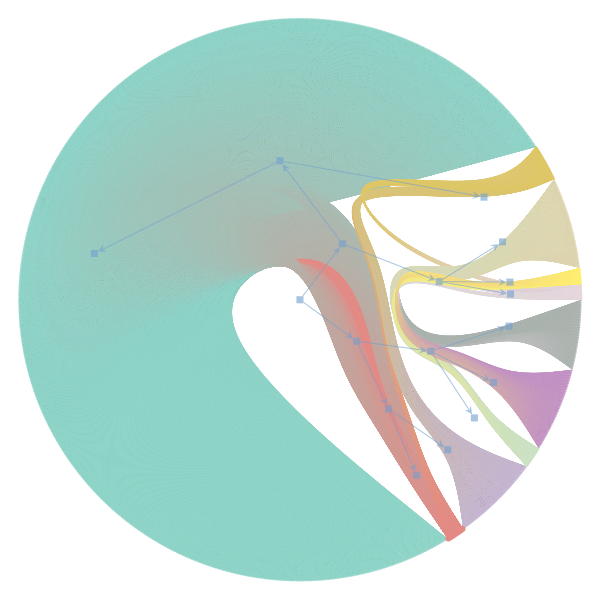

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fcdd831fbe0, at 0x7fce20d80358>,
 <Graph object, directed, with 1067 vertices and 1066 edges at 0x7fce20d93400>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fce20d93400, at 0x7fce20beb7b8>)

In [40]:
min_state.draw()

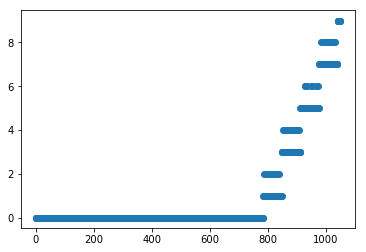

In [38]:
plt.scatter(range(g_max.num_vertices()), min_state.get_bs()[0])

<NestedBlockState object, with base <BlockState object with 6 blocks (6 nonempty), degree-corrected, for graph <GraphView object, undirected, with 1050 vertices and 4304 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fcd8065eb70, at 0x7fcd8065ef28>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fcd8065eb70, at 0x7fcd8065ef98>, False) at 0x7fcd8065eb70>, at 0x7fce20d0fdd8>, and 3 levels of sizes [(1050, 6), (6, 3), (3, 1)] at 0x7fce20e849e8>


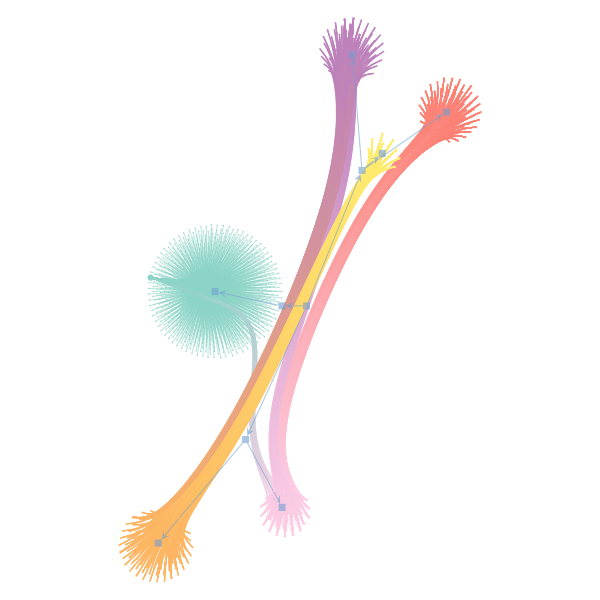

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fcd8065eb70, at 0x7fce20d80470>,
 <Graph object, directed, with 1060 vertices and 1059 edges at 0x7fce20e28710>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fce20e28710, at 0x7fce20e28908>)

In [23]:
from graph_tool.inference.minimize import minimize_nested_blockmodel_dl
min_state = minimize_nested_blockmodel_dl(g_min, B_max=6)
print(min_state)
min_state.draw(layout='sfdp')

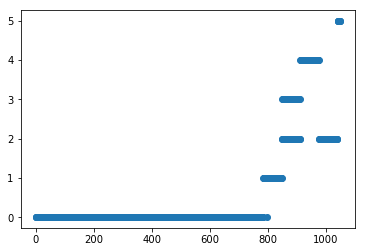

In [22]:
plt.scatter(range(g_min.num_vertices()), min_state.get_bs()[0])

In [9]:
import numpy as np
import graph_tool as gt
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense

def dense_model_to_graph(model):
    input_layer = model.layers[0]
    dense_layers = [l for l in model.layers if isinstance(l, Dense)]
    d = len(dense_layers)
    Ws = [layer.get_weights()[0] for layer in dense_layers]
    N = Ws[0].shape[0] + sum(W.shape[1] for W in Ws)
    edges = []
    i_in = 0
    for W in Ws:
        N_in, N_out = W.shape
        i_out = i_in + N_in
        edges += [(i, j) for i in range(i_in, i_out) for j in range(i_out, i_out + N_out)]
        i_in = i_out
    g = gt.Graph(directed=False)
    g.add_edge_list(edges)
    weights = np.concatenate([W.flatten() for W in Ws])
    g.ep['weight'] = g.new_edge_property('float', weights)
    return g

def dense_activations_to_graph(model, x_in, thresh=1.0E-5):
    G = dense_model_to_graph(model)
    input_layer = model.layers[0]
    dense_layers = [l for l in model.layers if isinstance(l, Dense)]
    dense_outputs = [layer.output for layer in dense_layers]
    dense_func = K.function(inputs=model.inputs, outputs=dense_outputs)
    outputs = dense_func(x_in)
    masks = [np.expand_dims(output > thresh, axis=1) for output in outputs]
    Ws = [np.tile(output, (1,layer.get_weights()[0].shape[0], 1)) for layer, output in zip(dense_layers, [x_in] + outputs)]
    Ws_masked = np.concatenate([(W*mask).reshape((-1, np.prod(W.shape[1:]))) for W, mask in zip(Ws, masks)], axis=1)
    edge_masks = ~np.isclose(Ws_masked, 0.0, atol=thresh)
    Gs = [gt.GraphView(G, efilt=G.new_ep('bool', vals=mask)) for mask in edge_masks]
    for g in Gs:
        g.vp['degree'] = g.degree_property_map('total', weight=g.ep['weight'])
    return G, Gs

dense_activations_to_graph(model, X_test)

ValueError: operands could not be broadcast together with shapes (1,7840000,784) (10000,1,64) 